In [110]:
import scipy as sp
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.special import gamma
import matplotlib.pyplot as plt
from scipy.io import loadmat
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd
import csv

def Kernel_X(mean,sd,X,Y):
    return (norm.cdf(X[1], mean[0], sd)-norm.cdf(X[0], mean[0], sd))#*(norm.cdf(Y[1], mean[1], sd)-norm.cdf(Y[0], mean[1], sd))

def Lambda(punti_generatori, D, bv, X,Y, sd, M):
    vet = [D[m]*Kernel_X(punti_generatori[m],sd,X,Y) for m in range(M**2)]
    return bv*sum(vet)

def conta_occorsi(punti_generatori, sigma):
    #occorrenze = np.sum(np.all(punti_generatori[:, np.newaxis, :] == sigma, axis=2), axis=1)

    conteggi = np.zeros(len(punti_generatori))
    for i in range(len(punti_generatori)):
        elem = punti_generatori[i]
        for elem1 in sigma:
            if np.array_equal(elem, elem1):
                conteggi[i] += 1
    return conteggi

def unisci_a_coppie(vettore1, vettore2):
    # Assicurati che i vettori abbiano la stessa lunghezza
    if len(vettore1) != len(vettore2):
        raise ValueError("error")

    # Unione a coppie
    vettore_unito = []
    for elemento1, elemento2 in zip(vettore1, vettore2):
        vettore_unito.append([elemento1, elemento2])

    return vettore_unito

In [111]:
months = []
with open('data/months.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader) 
    for row in reader:
        months.append(row[0])

T = len(months)
print(T, months)

3 ['01-August-2016', '01-September-2017', '01-September-2018']


In [112]:
lat_vet = loadmat('data/lat_vet.mat')
long_vet = loadmat('data/long_vet.mat')

lat_vet = [lat_vet['lat_vet'][0][t][0] for t in range(T)]
long_vet = [long_vet['long_vet'][0][t][0] for t in range(T)]

Nt = [len(lat_vet[t]) for t in range(T)]

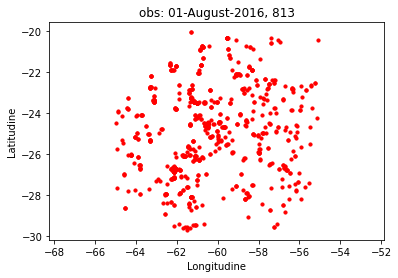

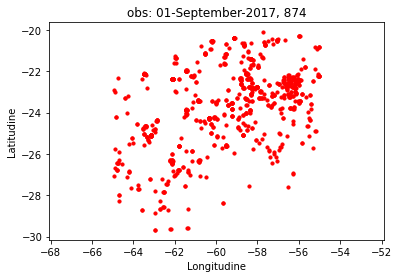

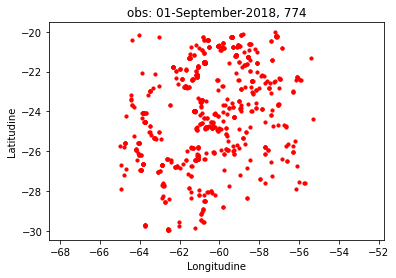

In [113]:
for t in range(T):
    df = gpd.GeoDataFrame(geometry=gpd.points_from_xy(long_vet[t], lat_vet[t]))

    df.plot(marker='o', color='red', markersize=10)
    plt.title(f'obs: {months[t]}, {Nt[t]}')
    plt.xlabel('Longitudine')
    plt.ylabel('Latitudine')
    plt.axis('equal')

    plt.show()

813
874
774


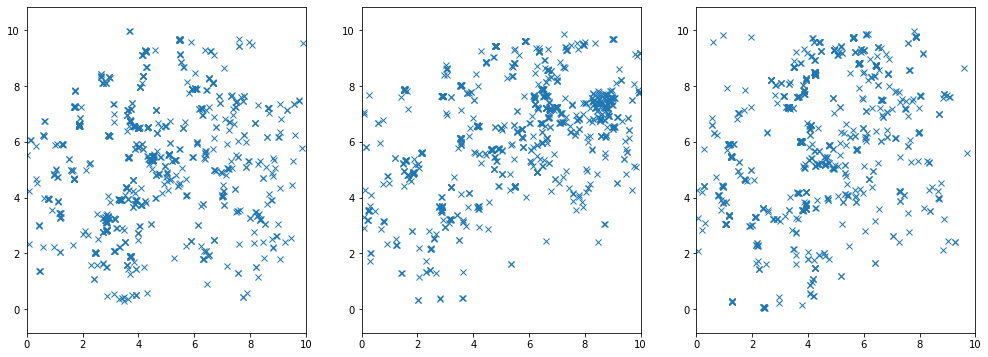

In [114]:
#stupid solution
#I will just traslate the coordinates "near the orgin" 
obs_x_vector = []
obs_y_vector = []
fig = plt.figure(figsize=(17, 6))
for t in range(T):
    
    lat = lat_vet[t]
    y_obs = (lat + 30*np.ones(np.size(lat)))#*1/10
    obs_y_vector.append(y_obs)

    long= long_vet[t]
    x_obs = (long + 65*np.ones(np.size(long)))#*1/10
    obs_x_vector.append(x_obs)


    
    plt.subplot(1, 3, t+1)
    plt.plot(x_obs, y_obs, "x")
    plt.axis('equal')

    print(np.size(lat))

    plt.xlim(0, 10)
    plt.ylim(0, 10)

In [115]:
sd = 0.8
X = [0,10]
Y = [0,10]
M = 8 #square root of the total locations
a = X[0]
b = X[1]
c = Y[0]
d = Y[1]

x = np.arange(a + (b-a)/(2*M),b,(b-a)/M)
x = np.tile(x, M)
y = np.arange(c + (d-c)/(2*M),d,(d-c)/M)
y = np.repeat(y, M)

punti_generatori = unisci_a_coppie(x, y)

In [116]:
#simulation

it = 5000
sigma = [np.zeros((it,Nt[t],2)) for t in range(T)]
Dmcmc = [np.zeros([it,M**2]) for t in range(T)]
Bv = [np.zeros(it) for t in range(T)]
bv_curr = [1000 for t in range(T)]

Beta = np.zeros(it)
betacurr = 0.05

Alpha = np.zeros(it)
alphacurr = 50
alpha0 = alphacurr


DD = [np.ones(M**2) for t in range(T)]
Lambdamcmc = [np.zeros(it) for t in range(T)]

KK = [np.zeros([Nt[t],len(x)]) for t in range(T)] 

for t in range(T):
    for i in range(Nt[t]):
        KK[t][i][:] = norm.pdf(obs_x_vector[t][i],x,sd)*norm.pdf(obs_y_vector[t][i],y,sd)

U1 = [np.random.uniform(0,1,it) for t in range(T)]
U2 = np.random.uniform(0,1,it)

acc = 0
acc2 = 0

def prior(alphafun):
    return norm.pdf(alphafun, alpha0, 3/2*alpha0)

def logtarget(D,alphatarget,bv,M,beta,T):
    alpha_l = alphatarget/(M**2)
    c1 = np.log(prior(alphatarget))
    c2 = (alphatarget-1)*sum(np.log(bv))
    c3 = alphatarget*T*np.log(beta)
    c4 = (alpha_l-1)*sum(sum([np.log(D[t]) for t in range(T)])) 
    c5 = (M**2)*T*np.log(gamma(alpha_l))
    return c1+c2+c3+c4-c5


#del alphatot, beta, D, bv, LL

for m in range(it):
    for t in range(T):
        N = Nt[t]
        #1
        for i in range(N):
            prob = DD[t]*KK[t][i,:]/sum(DD[t]*KK[t][i,:])
            punto = np.random.choice(M**2,p = prob)
            sigma[t][m,i] = punti_generatori[punto]

        #2
        conteggi = conta_occorsi(punti_generatori, sigma[t][m,:])
        #print("conteggi", conteggi)
        alpha_dirr = alphacurr/(M**2)*np.ones(M**2)+conteggi
        D_new = np.random.dirichlet(alpha_dirr)
        if np.log(U1[t][m]) <= -Lambda(punti_generatori, D_new, bv_curr[t], X,Y, sd, M) +Lambda(punti_generatori, DD[t], bv_curr[t], X,Y, sd, M):
            Dmcmc[t][m,:] = D_new
            acc = acc+1
            #print("acc")
        else:
            Dmcmc[t][m,:] = DD[t]

        #3
        DD[t] = Dmcmc[t][m,:]
        s = sum([DD[t][m]*Kernel_X(punti_generatori[m],sd,X,Y) for m in range(M**2)])
        Bv[t][m] = np.random.gamma(shape = alphacurr+N, scale =1/(betacurr + s))
        bv_curr[t] = Bv[t][m]

    #4
    p = sum([Bv[t][m] for t in range(T)])
    Beta[m] = np.random.gamma(1+alphacurr*T,scale=1/(0.01+p))
    betacurr = Beta[m]

    #5
    alpha_new = max(np.random.normal(alphacurr, 5),.001)
    P = logtarget(DD,alpha_new,bv_curr,M,betacurr,T) - logtarget(DD,alphacurr,bv_curr,M,betacurr,T)
    if np.log(U2[m]) < P:
        Alpha[m] = alpha_new
        acc2 = acc2 + 1
    else: 
        Alpha[m] = alphacurr
    
    alphacurr =  Alpha[m]
    for t in range(T):
        Lambdamcmc[t][m] = Lambda(punti_generatori, DD[t], bv_curr[t], X,Y, sd, M)


print(acc,acc2)



1556 931


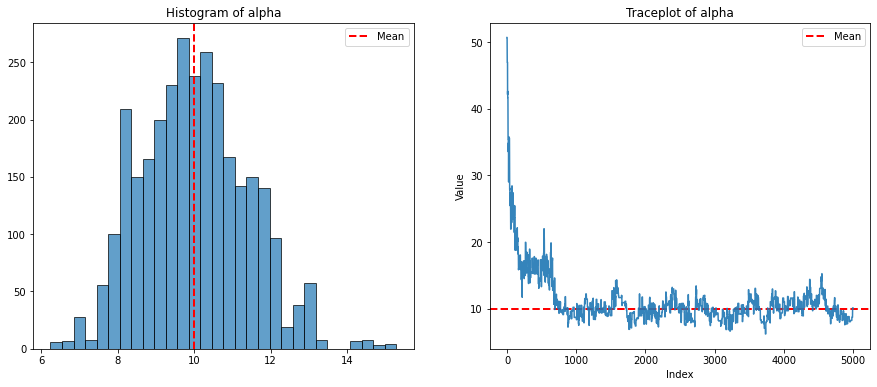

In [134]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1,2,1)
plt.hist(Alpha[2000:], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=np.mean(Alpha[2000:]), color='red', linestyle='--', linewidth=2,label='Mean')
plt.title('Histogram of alpha')
plt.legend()

ax = fig.add_subplot(1,2,2)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Traceplot of alpha')
plt.axhline(y=np.mean(Alpha[2000:]), color='red', linestyle='--', linewidth=2, label='Mean')
plt.plot(Alpha, alpha = 0.9)
plt.legend()

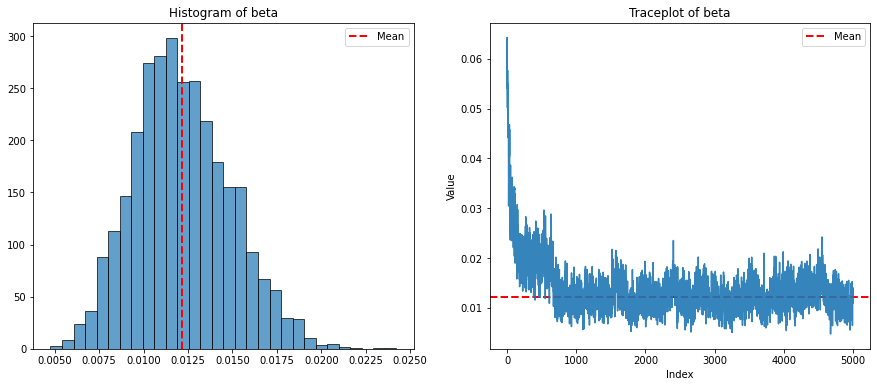

In [133]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1,2,1)
plt.hist(Beta[2000:], bins = 30, edgecolor='black', alpha=0.7)

plt.axvline(x=np.mean(Beta[2000:]), color='red', linestyle='--', linewidth=2, label='Mean')
plt.title("Histogram of beta")
plt.legend()

ax = fig.add_subplot(1,2,2)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Traceplot of beta')
plt.axhline(y=np.mean(Beta[2000:]), color='red', linestyle='--', linewidth=2, label='Mean')
plt.plot(Beta, alpha = 0.9)
plt.legend()



(array([  1.,   8.,  49., 143., 259., 448., 593., 696., 642., 586., 451.,
        330., 262., 181., 122.,  90.,  47.,  32.,  19.,  15.,   5.,   8.,
          5.,   3.,   2.,   1.,   0.,   1.,   0.,   1.]),
 array([ 426.15504976,  473.96439269,  521.77373562,  569.58307855,
         617.39242148,  665.20176441,  713.01110734,  760.82045027,
         808.6297932 ,  856.43913613,  904.24847906,  952.05782199,
         999.86716491, 1047.67650784, 1095.48585077, 1143.2951937 ,
        1191.10453663, 1238.91387956, 1286.72322249, 1334.53256542,
        1382.34190835, 1430.15125128, 1477.96059421, 1525.76993714,
        1573.57928007, 1621.388623  , 1669.19796593, 1717.00730886,
        1764.81665179, 1812.62599472, 1860.43533765]),
 <BarContainer object of 30 artists>)

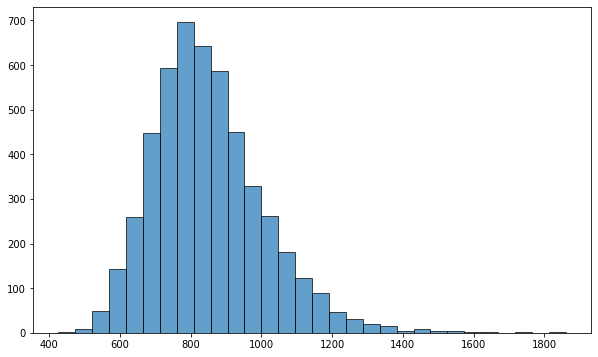

In [119]:
fig = plt.figure(figsize=(10, 6))
rapporto = [Alpha[i]/Beta[i] for i in range(it)]
plt.hist(rapporto, bins = 30, edgecolor='black', alpha=0.7)


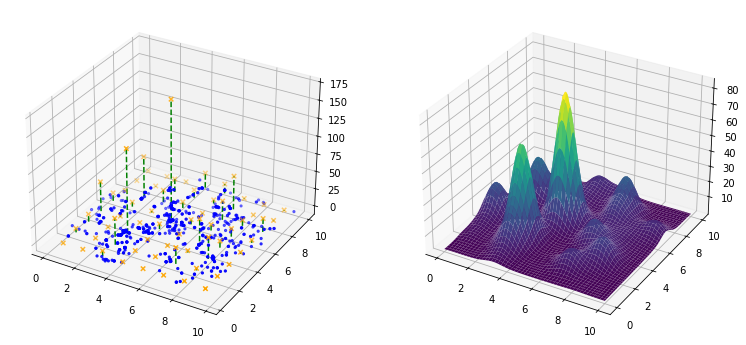

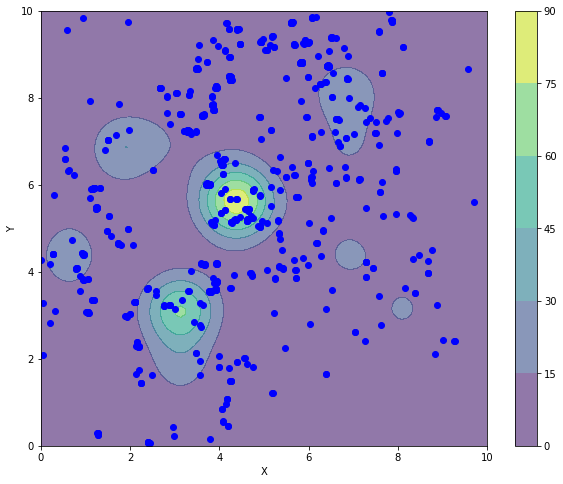

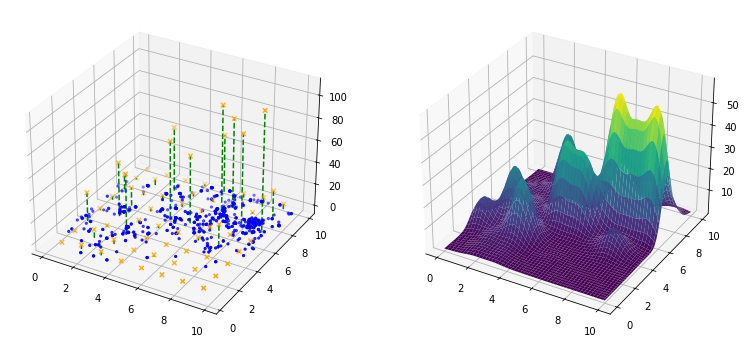

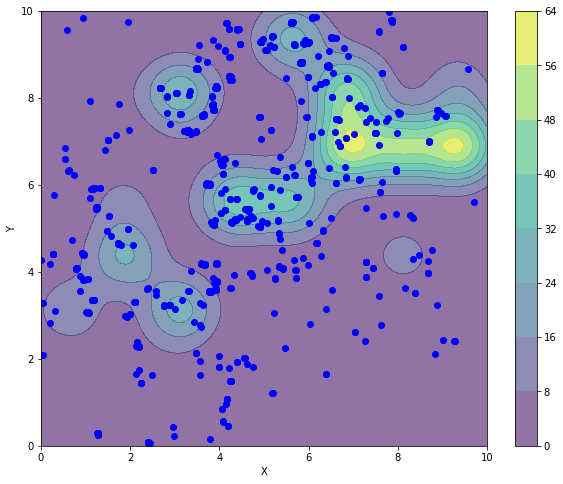

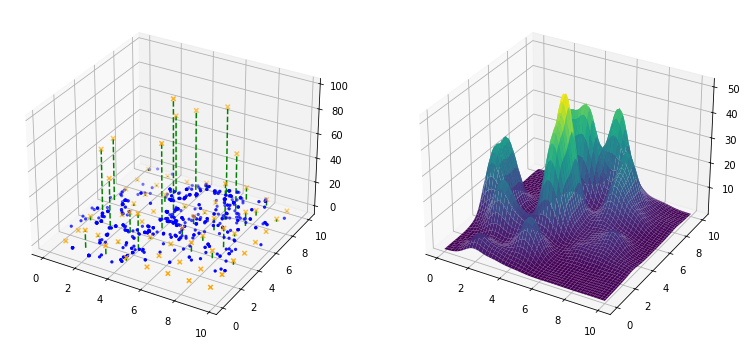

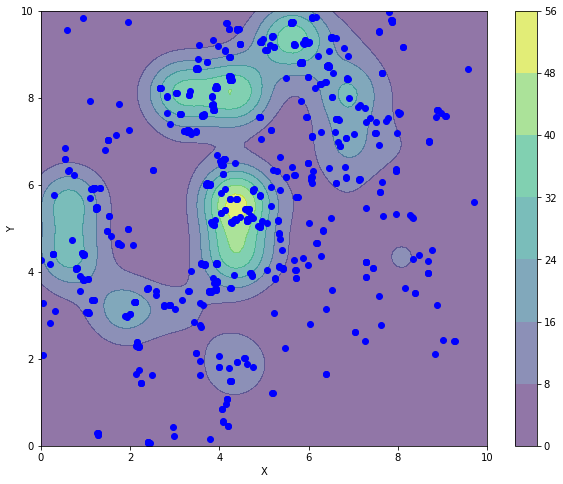

In [149]:
Vmcmc = []
V_mean = []
kernel = lambda x,y, mean: 1/(np.pi*(sd**2))*np.exp(-((x- mean[0])**2 + (y- mean[1])**2)/(sd**2))

def Lambda_dx(x,y,weight_mean):
    value = 0
    for m in range(np.size(weight_mean)):
        mean = punti_generatori[m]
        weight = weight_mean[m]
        #print(mean, weight, x,y)
        value = value + weight*kernel(x,y,mean)

    return value

x1 = np.linspace(X[0], X[1], 100)
y1 = np.linspace(Y[0], Y[1], 100)
X1,Y1 = np.meshgrid(x1, y1)

for t in range(T):
    fig = plt.figure(figsize=(20, 10))
    Vmcmc.append([Bv[t][:]*Dmcmc[t][:,m] for m in range(M**2)])
    V_mean.append([np.mean(Vmcmc[t][:][m]) for m in range(M**2)])

    # Tracciamento dei dati
    
    #plt.subplot(3, 1, 1)
    ax = fig.add_subplot(131, projection='3d')
    #ax.scatter(x, y, D_final, c='r', marker='x')
    ax.scatter(x, y, V_mean[t], c='orange', marker='x')
    #ax.scatter(x_obs, y_obs, np.zeros(np.size(x_obs)), c='g', marker='.')

    ax.scatter(obs_x_vector[t], obs_y_vector[t], np.zeros(Nt[t]), c='b', marker='.')

    for i in range(len(x)):
        #ax.plot([x[i], x[i]], [y[i], y[i]], [0, D_final[i]], color='blue', linestyle='--')
        ax.plot([x[i], x[i]], [y[i], y[i]], [0, V_mean[t][i]], color='green', linestyle='--')

    #plt.title("Plot of the coordinates of the fires \n with estimates for the weights of the latent process")

    Z = Lambda_dx(X1,Y1, V_mean[t])
    #plt.subplot(3, 1, 2)
    ax = fig.add_subplot(132, projection='3d')
    surf = ax.plot_surface(X1, Y1, Z, cmap='viridis')
    #plt.title("Surface plot of Lambda(E)")

    fig = plt.figure(figsize=(10, 8))
    plt.contourf(X1, Y1, Z, cmap='viridis', alpha=0.6)
    plt.colorbar()  # Aggiunta della barra dei colori
    plt.xlabel('X')
    plt.ylabel('Y')
    #plt.title('Contour Plot di Lambda(X)')
    plt.plot(x_obs,y_obs,"o",color='blue')
    #plt.title("Plot of the coordinates of the fires over the contour plot of Lambda(E)")
    plt.show()
  